## usage
```first run pip install -e . ```
from cocite/mlpipeline/

which command creates an editable install

In [70]:
# import package from mlpipeline
from config import cmd_arguments
import cocitedata as cocitedata
import citation_normalization as cn
import matplotlib.pyplot as plt
import os
import pandas as pd
import tqdm

import plotly.graph_objects as go


num_documents = 10000

def load_data():
    testargs = ["--data_dir", "../../external_projects/bva-citation-prediction/data/preprocessed-cached/preprocessed-cached-v4/", 
    # "--samples", str(num_documents),
    #"--rebuild_dataset",
    "--dont_normalize_citations"
    ]

    args = cmd_arguments(testargs=testargs)
    data_dir_name = cocitedata.dataset_filepath(args)
    cocitedata.generate_ds_if_not_cached(data_dir_name, args)
    parquet_files = [os.path.join(data_dir_name, f) for f in os.listdir(data_dir_name) if f.endswith('.parquet')]
    return parquet_files

normalization_types = ["no normalization", "normalized", "no sub subsections", "no subsections"]


In [2]:
files = load_data()

counts = {}
segmented_counts = {}
for ntype in normalization_types:
    counts[ntype] = pd.Series(dtype=int)
    segmented_counts[ntype] = pd.Series(dtype=int)

examples = []
for path in tqdm.tqdm(files):
    df = pd.read_parquet(path)
    df["no normalization"] = df["label"].copy()
    df["normalized"] = df.apply(lambda row: cn.normalize_citation(row["label"], remove_subsections=False, remove_subsubsections=False), axis=1)
    df["no sub subsections"] = df.apply(lambda row: cn.normalize_citation(row["label"], remove_subsections=False, remove_subsubsections=True), axis=1)
    df["no subsections"] = df.apply(lambda row: cn.normalize_citation(row["label"], remove_subsections=True, remove_subsubsections=True), axis=1)
 
    for ntype in normalization_types:        
        counts[ntype] = counts[ntype].add(df[ntype].value_counts(), fill_value=0)

        segmented = df.apply(lambda row: cn.segmentize_citation(row[ntype]), axis=1)
        segmented = segmented.apply(pd.Series).stack().reset_index(drop = True)
        segmented_counts[ntype] = segmented_counts[ntype].add(segmented.value_counts(), fill_value=0)        
        
        examples.append(df.loc[1][ntype])


100%|██████████| 3244/3244 [1:32:56<00:00,  1.72s/it]


In [6]:


# number of unique values in each normalization type
bars = []
segmented_bars = []
for ntype in normalization_types:
    bars.append(len(counts[ntype]))
    segmented_bars.append(len(segmented_counts[ntype]))

total_count = counts["no normalization"].sum()
titles = [ntype + ": \n" + example for (ntype, example) in zip(normalization_types, examples)]



NameError: name 'examples' is not defined

In [69]:
# horizontal bar chart
fig = go.Figure()

fig.add_bar(x=bars, y=titles, orientation="h", name="not segmented")
fig.add_bar(x=segmented_bars, y=titles, orientation="h", name="segmented")
# stacked bars
# fig.update_layout(barmode="stack")

fig.update_layout(title_text="Citation normalization")
fig.update_yaxes(title_text="normalization types")
fig.update_xaxes(title_text=f"number of unique citations (from total of {int(total_count)} citation pairs)")
# make xaxes labels vertical
fig.update_layout(xaxis_tickangle=-90)

fig.update_layout(width=900, height=500)
fig.show()


NameError: name 'titles' is not defined

In [180]:
# log to wandb 
import wandb
wandb.init(project="cocite", tags=["data_analysis"], name="citation_normalization bar chart")


wandb: Network error (ConnectionError), entering retry loop.


In [6]:
# save plot to file
fig.write_html("citation_normalization.html")
wandb.log({"citation_normalization_bar_chart": fig})

In [9]:
# save counts to file
# create folder for counts if it doesn't exist
if not os.path.exists("normed_citation_counts"):
    os.makedirs("normed_citation_counts")
for ntype in normalization_types:
    counts[ntype].to_csv(f"normed_citation_counts/{ntype}.csv")
    segmented_counts[ntype].to_csv(f"normed_citation_counts/{ntype}_segmented.csv")


In [48]:
# load data from csv files
counts = {}
segmented_counts = {}
for ntype in normalization_types:
    counts[ntype] = pd.read_csv(f"normed_citation_counts/{ntype}.csv")
    segmented_counts[ntype] = pd.read_csv(f"normed_citation_counts/{ntype}_segmented.csv")
    # read from csv into pandas series
    counts[ntype].columns = ["citation", "occurrences"]
    segmented_counts[ntype].columns = ["citation", "occurrences"]

    counts[ntype] = counts[ntype].set_index("citation")
    segmented_counts[ntype] = segmented_counts[ntype].set_index("citation")

    counts[ntype] = counts[ntype]["occurrences"]
    segmented_counts[ntype] = segmented_counts[ntype]["occurrences"]


In [49]:
total_count = counts["no normalization"].sum()

In [50]:
# relative counts
relative_counts = {}
relative_segmented_counts = {}
for ntype in normalization_types:
    relative_counts[ntype] = counts[ntype] / total_count
    relative_segmented_counts[ntype] = segmented_counts[ntype] / total_count



In [78]:
# sum all citations with less than 20 occurrences
summed_counts = {}
summed_segmented_counts = {}
relative_counts_summed = {}
relative_segmented_counts_summed = {}

for ntype in ["normalized"]:
    total_count = counts[ntype].sum()
    total_segmented_count = segmented_counts[ntype].sum()

    summed_counts[ntype] = (counts[ntype][counts[ntype] >= 20].sum())# / total_count
    summed_segmented_counts[ntype] = (segmented_counts[ntype][segmented_counts[ntype] >= 20].sum())# / total_segmented_count

    summed_counts[ntype] = int(summed_counts[ntype])
    relative_counts_summed[ntype] = round(summed_counts[ntype] / total_count, 3)
    print(f"total number of citations with >= 20 occurrences: \
        {summed_counts[ntype]} ({relative_counts_summed[ntype]})")
    
    summed_segmented_counts[ntype] = int(summed_segmented_counts[ntype])
    relative_segmented_counts_summed[ntype] = round(summed_segmented_counts[ntype] / total_segmented_count, 3)
    print(f"total number of segmented citations with >= 20 occurrences:\
        {summed_segmented_counts[ntype]} ({relative_segmented_counts_summed[ntype]})")




total number of citations with >= 20 occurrences:         6824295 (0.975)
total number of segmented citations with >= 20 occurrences:        9113302 (0.991)


In [53]:
fig = go.Figure()
fig.add_bar(y=counts["normalized"].nlargest(10).index, x=counts["normalized"].nlargest(10).values, orientation="h", name="not segmented")
fig.update_layout(title_text="Most common normalized citations")
fig.update_yaxes(title_text="citations")
fig.update_xaxes(title_text=f"absolute frequency")

fig.show()
wandb.log({"most common normalized citations (not segmented)": fig})

# segmented
fig = go.Figure()
fig.add_bar(y=segmented_counts["normalized"].nlargest(10).index, x=segmented_counts["normalized"].nlargest(10).values, orientation="h", name="segmented")
fig.update_layout(title_text="Most common normalized citations (segmented)")
fig.update_yaxes(title_text="citations")
fig.update_xaxes(title_text=f"absolute frequency")

fig.show()
wandb.log({"most common normalized citations (segmented)": fig})


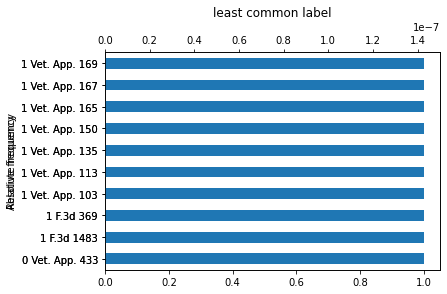

In [22]:
plt.title("least common label")
segmented_counts["normalized"].nsmallest(10).plot(kind="barh")
# ylabel
plt.ylabel("Relative frequency")
# second ylabel absolute frequency
plt.twiny()
relative_segmented_counts["normalized"].nsmallest(10).plot(kind="barh")
plt.ylabel("Absolute frequency")
plt.show()


In [71]:
import plotly.express as px

def plot_percentiles(x, counts, segmented_counts):
    # segmented
    citations_per_percentile = counts.quantile(percentiles)

    segmented_citations_per_percentile = segmented_counts.quantile(x)
    # fig = px.scatter(x=percentiles, y=citations_per_percentile, labels={"x": "percentile", "y": "avg Number of citations"}, log_y=True)
    # same with segmented and non segmented in one scatter plot
    fig = px.scatter(x=x, y=citations_per_percentile, labels={"x": "percentile", "y": "avg Number of citations"}, log_y=True)
    # modes are "lines+markers", "lines", "markers", "lines+markers+text", "none"
    fig.add_trace(go.Scatter(x=percentiles, y=segmented_citations_per_percentile, name="segmented", mode="markers"))
    # add name for non segmented
    fig.add_trace(go.Scatter(x=percentiles, y=citations_per_percentile, name="non segmented", mode="markers"))


    title = "percentiles of occurences per unique citation"
    fig.update_layout(title_text=title)
    fig.update_xaxes(title_text="percentile")
    fig.update_yaxes(title_text="occurrences")
    return fig

In [72]:
percentiles = [(i/100) for i in range(0, 100)]

fig = plot_percentiles(percentiles, counts["normalized"], segmented_counts["normalized"])
# segmented
# fig = plot_percentiles(percentiles, segmented_counts["normalized"])
fig.show()
# log wandb
wandb.log({"percentiles of occurences per citation": fig})


In [179]:
# compute buckets from total number of citations
import numpy as np

def plot_buckets_occurrences(counts):
    num_buckets = 15
    buckets = np.linspace(0, total_count, num_buckets + 1)
    buckets = [int(i) for i in buckets]
    buckets[-1] = total_count

    # partial sums for all citations
    partial_sums = {}
    partial_sums_segmented = {}
    for ntype in ["normalized"]:
        sorted_counts = counts[ntype].sort_values()
        # to int
        sorted_counts = sorted_counts.astype(int)
        partial_sums[ntype] = np.cumsum(sorted_counts)
        partial_sums_segmented[ntype] = np.cumsum(segmented_counts[ntype])
        
        # get number of elements is smaller partial_sums[ntype][bucket]
        avg_occurrences_per_quantile = []
        indexes = [0]
        xticks = []
        for bucket in buckets:
            index = len(partial_sums[ntype][partial_sums[ntype] < bucket])
            if sorted_counts[index] >= 1000 and sorted_counts[index] < 1000000:
                # round to 2 digits in f string
                occurrence_range = f"occurences: {sorted_counts[indexes[-1]]//1000}k-{sorted_counts[index]//1000}k"
                
            else:
                occurrence_range = f"{sorted_counts[indexes[-1]]}-{sorted_counts[index]}"
            # print(occurrence_range)
            avg = sorted_counts[indexes[-1]:index].mean()
            indexes.append(index)
            avg_occurrences_per_quantile.append(avg)
            xticks.append(occurrence_range)

        fig = go.Figure()
        fig.add_bar(y=avg_occurrences_per_quantile[1:], x=xticks[1:], name="not segmented")
        fig.update_layout(title_text="Average number of citations per quantile", yaxis_type="log")
        fig.update_yaxes(title_text="average number of occurences per quantile")    
        

        fig.update_layout(title_text="average occurrences per quantile of all citations (not segmented)")
        fig.update_xaxes(title_text=f"buckets with average occurences per citation. Each bucket contains {buckets[1]} citations, per bucket the occurance range is shown in the x-axis")

        return fig


fig = plot_buckets_occurrences(counts)
fig.show()
# save to wandb
wandb.log({"average occurrences of all citations (not segmented)": fig})

# segmented
fig = plot_buckets_occurrences(segmented_counts)
# title segmented
fig.update_layout(title_text="average occurrences of all citations (segmented)")
fig.show()
# save to wandb
wandb.log({"average occurrences of all citations (segmented)": fig})
